In [60]:
import numpy as np
import statmapper as stm
from sklearn_tda import MapperComplex
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.cluster import AgglomerativeClustering

""" 
Slight change needed to /path_to_python/site-packages/sklearn_tda/vector_methods.py 
Should be:
from sklearn.metrics import DistanceMetric
"""

from sklearn_tda import clustering

Load data.

In [61]:
X = np.loadtxt("human")


Compute Mapper with `sklearn_tda`

In [86]:
""" params = {"filters": X[:,2:3], "filter_bnds": np.array([[np.nan,np.nan]]), "colors": X, 
          "resolutions": np.array([24]), "gains": np.array([0.3]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=.1)} """

params = {"filters": X[:,2:3], "filter_bnds": np.array([[np.nan,np.nan]]), "colors": X, 
          "resolutions": np.array([np.nan]), "gains": np.array([0.5,0.3]), "inp": "point cloud", 
          "clustering": AgglomerativeClustering(n_clusters=None, linkage="single", distance_threshold=0.07258713574299733)}

In [87]:
M = MapperComplex(**params).fit(X)

In [88]:
MapperComplex?

Init signature:
MapperComplex(
    filters,
    filter_bnds,
    colors,
    resolutions,
    gains,
    inp='point cloud',
    clustering=DBSCAN(),
    mask=0,
    N=100,
    beta=0.0,
    C=10.0,
)
Docstring:      This is a class for computing Mapper simplicial complexes on point clouds or distance matrices. 
Init docstring:
Constructor for the MapperComplex class.

Attributes:
    inp (string): either "point cloud" or "distance matrix". Specifies the type of input data.
    filters (numpy array of shape (num_points) x (num_filters)): filters (sometimes called lenses) used to compute the Mapper. Each column of the numpy array defines a scalar function defined on the input points.
    filter_bnds (numpy array of shape (num_filters) x 2): limits of each filter, of the form [[f_1^min, f_1^max], ..., [f_n^min, f_n^max]]. If one of the values is numpy.nan, it can be computed from the points with the fit() method.
    colors (numpy array of shape (num_points) x (num_colors)): functions use

In [89]:
clustering.estimate_scale(X)

0.07471593287694134

In [90]:
MapperComplex(**params).get_optimal_parameters_for_agglomerative_clustering(X)

(0.07415299043446463, array([24]))

Print Mapper to `.dot` file that can then be processed with the open source [`graphviz`](https://www.graphviz.org/) library.

In [67]:
""" stm.print_to_dot(M) """

' stm.print_to_dot(M) '

Display Mapper with `networkx` library.

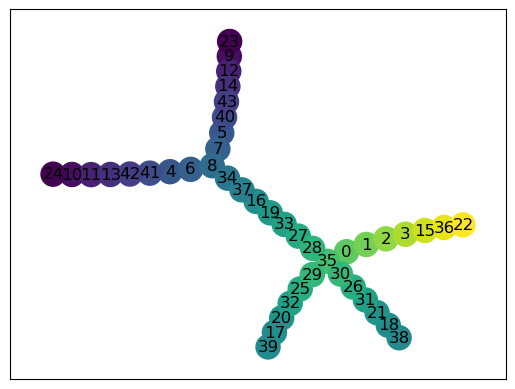

In [91]:
""" 
G = stm.mapper2networkx(M)
nx.draw(G, pos=nx.kamada_kawai_layout(G), 
        node_color=[M.node_info_[node]["colors"][2] for node in G.nodes()])
plt.show()
"""

""" Error with code above """

G = stm.mapper2networkx(M)
nx.draw_networkx(G,pos=nx.kamada_kawai_layout(G),
                 node_color=[M.node_info_[node]["colors"][2] for node in G.nodes()])
plt.show()

Define function and topological feature type with which we will compute persistence on the Mapper. In the cell below, the function is defined as the 3rd coordinate of the point cloud and the feature type is downward branch.

In [69]:
function = X[:,2]
topo = "downbranch"

Compute downbranches and their representative nodes.

In [70]:
dgm, bnd = stm.compute_topological_features(M, function, "data", topo)

In [71]:
print(dgm, bnd)

[(0, (-0.9480552172131147, -0.34869331954887217)), (0, (-0.13627077272727273, 0.2555371930232558)), (0, (-0.13681168888888887, 0.2555371930232558)), (0, (-0.9481028442622951, 0.7633437231270359))] [[23, 9, 12, 14, 43, 40, 5, 7, 8], [39, 17, 20, 32, 25, 29, 35], [38, 18, 21, 31, 26, 30, 35], [24, 10, 11, 13, 42, 41, 4, 6, 8, 34, 37, 16, 19, 33, 27, 28, 35, 0, 1, 2, 3, 15, 36, 22, 22]]


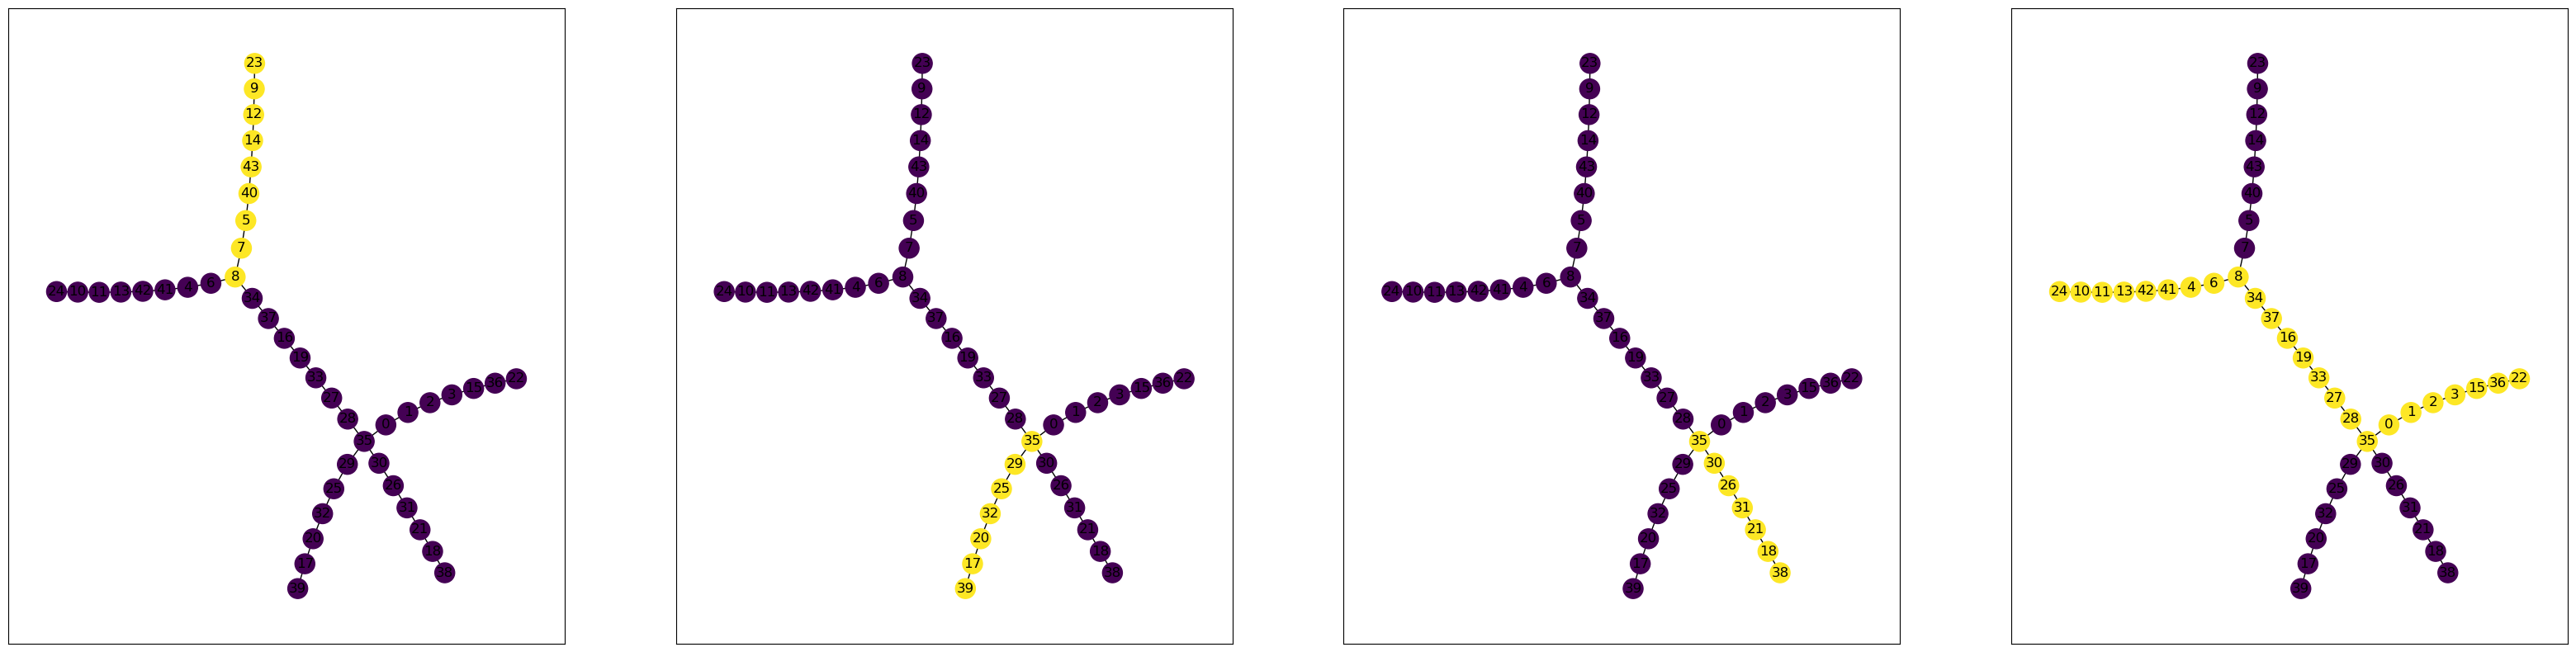

In [72]:
""" 
G = stm.mapper2networkx(M)
plt.figure(figsize=(40,10))
for idx, bd in enumerate(bnd):
    plt.subplot(1,len(bnd),idx+1)
    nx.draw(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()])
plt.show()

"""

G = stm.mapper2networkx(M)
plt.figure(figsize=(40,10))
for idx, bd in enumerate(bnd):
    plt.subplot(1,len(bnd),idx+1)
    nx.draw_networkx(G, pos=nx.kamada_kawai_layout(G), 
            node_color=[1 if node in bd else 0 for node in G.nodes()])
plt.show()

Filter downbranches with significance less than 90% with 100-bootstrap.

In [73]:
confidence = 0.90
bootstrap  = 100

In [74]:
sdgm, sbnd = stm.evaluate_significance(dgm, bnd, X, M, function, params, topo, confidence, bootstrap)

In [75]:
print(sdgm, sbnd)

[(0, (-0.9480552172131147, -0.34869331954887217)), (0, (-0.13627077272727273, 0.2555371930232558)), (0, (-0.13681168888888887, 0.2555371930232558)), (0, (-0.9481028442622951, 0.7633437231270359))] [[23, 9, 12, 14, 43, 40, 5, 7, 8], [39, 17, 20, 32, 25, 29, 35], [38, 18, 21, 31, 26, 30, 35], [24, 10, 11, 13, 42, 41, 4, 6, 8, 34, 37, 16, 19, 33, 27, 28, 35, 0, 1, 2, 3, 15, 36, 22, 22]]


Sort coordinates with respect to their ability to differentiate the first significant downbranch from the rest of the Mapper nodes.

In [76]:
features, pv = stm.compute_DE_features(X, M, sbnd[0])

In [77]:
print(features, pv)

[2 0 1] [5.43472210e-322 1.03047633e-176 1.67829244e-022]


In [92]:
M.gains

array([0.5, 0.3])